In [1]:
import os, sys
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path_to_file= r"/workspaces/project-final/vietnam_housing_dataset.csv"
vietnam_housing = pd.read_csv(r"/workspaces/project-final/vietnam_housing_dataset.csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage','Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

## Chia dữ liệu


In [4]:
from sklearn.model_selection import train_test_split
seed = 42
index_all = np.arange(vietnam_housing.shape[0])
index_train, index_test = train_test_split(index_all, test_size=0.33, random_state=seed)

In [5]:
vietnam_housing_train = vietnam_housing.iloc[index_train]
vietnam_housing_test  = vietnam_housing.iloc[index_test]
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [6]:
# Lưu dữ liệu sau khi chia
import os
from pathlib import Path
# define experiment directory (change if you prefer another path)
exps_dir = Path("./exps")
(exps_dir / "data").mkdir(parents=True, exist_ok=True)
vietnam_housing_train.to_excel(f'{exps_dir}/data/train.xlsx', index=None)
vietnam_housing_test.to_excel(f'{exps_dir}/data/test.xlsx', index=None)
np.savez(f'{exps_dir}/data/idx.npz', id_train = index_train, id_test = index_test)


In [7]:
pd.read_excel(f'{exps_dir}/data/train.xlsx')

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Đường Ngọc Lâm, Phường Bồ Đề, Long Biên, Hà Nội",44.6,NaN,NaN,NaN,NaN,6.0,3.0,4.0,Have certificate,Full,9.35
1,"Đường Thế Lữ, Phường An Hải Bắc, Sơn Trà, Đà ...",94.6,4.3,5.5,Đông - Nam,NaN,3.0,3.0,3.0,Have certificate,NaN,5.30
2,"358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...",71.4,4.0,6.0,Nam,Nam,4.0,4.0,3.0,Have certificate,Full,5.95
3,"Đường Định Công Thượng, Phường Định Công, Hoàn...",50.0,4.0,NaN,NaN,NaN,5.0,4.0,4.0,Have certificate,Full,7.05
4,"Đường Số 6, Phường Linh Tây, Thủ Đức, Hồ Chí Minh",74.0,4.0,10.0,Tây - Bắc,Tây - Bắc,3.0,4.0,4.0,Have certificate,NaN,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...
20248,"Đường Lê Văn Thọ, Phường 16, Gò Vấp, Hồ Chí Minh",75.0,4.0,6.0,Đông - Bắc,Đông - Bắc,2.0,3.0,3.0,Have certificate,Full,6.50
20249,"Xã Tân Bình, Vĩnh Cửu, Đồng Nai",105.0,7.0,7.0,NaN,NaN,2.0,4.0,3.0,Have certificate,Full,1.70
20250,"Đường Cầu Diễn, Phường Cầu Diễn, Nam Từ Liêm, ...",34.0,NaN,NaN,NaN,NaN,5.0,5.0,NaN,Have certificate,Basic,5.25
20251,"Đường Nguyễn Phẩm, Phường Hòa Cường Bắc, Hải C...",82.5,5.5,5.5,Tây - Nam,NaN,NaN,2.0,NaN,Have certificate,NaN,5.20


## Tiền xử lý dữ liệu

In [8]:
# create explicit copies of the splits
vietnam_housing_train = vietnam_housing.iloc[index_train].copy()
vietnam_housing_test  = vietnam_housing.iloc[index_test].copy()
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 20253 / test: 9976 - Tỷ lệ: 0.670, 0.330


In [9]:
vietnam_housing_train.isna().any()

Address              False
Area                 False
Frontage              True
Access Road           True
House direction       True
Balcony direction     True
Floors                True
Bedrooms              True
Bathrooms             True
Legal status          True
Furniture state       True
Price                False
dtype: bool

In [10]:
vietnam_housing_train.dropna(inplace=True)

In [11]:
vietnam_housing_train.drop_duplicates(inplace=True)

In [12]:
# Safe NA fill: tìm biến với khoảng trắng hoặc gạch dưới trước khi fillna
vietnam_housing_train = vietnam_housing_train.copy()

def colname(df, name):
    for cand in (name, name.replace(' ', '_'), name.lower().replace(' ', '_')):
        if cand in df.columns:
            return cand
    return None

for src in ['Frontage','Access Road','Floors','Bedrooms','Bathrooms','Area','Price']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna(vietnam_housing_train[c].median())
    else:
        print(f"Warning: numeric column not found: {src}")

for src in ['House direction','Balcony direction','Legal status','Furniture state','Address']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna('Unknown')
    else:
        print(f"Warning: categorical column not found: {src}")
# ...existing code...

In [13]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing_train.drop_duplicates(inplace=True)
vietnam_housing_train.describe()

,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Price
count,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000
mean,69.407621,5.445282,7.536077,3.232807,3.446449,3.350620,5.433754
std,48.324289,4.892505,7.355552,1.275137,1.166464,1.334584,2.206779
min,3.100000,1.000000,1.300000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.700000
50%,60.000000,4.500000,5.000000,3.000000,3.000000,3.000000,5.200000
75%,81.075000,5.000000,8.000000,4.000000,4.000000,4.000000,7.137500
max,501.000000,69.000000,85.000000,7.000000,9.000000,9.000000,10.000000


## Chuẩn hóa dữ liệu

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing_train = pd.DataFrame(vietnam_housing_train)
vietnam_housing_clean = vietnam_housing_train.copy()

def find_col(df, name):
    for cand in (name, name.replace(' ', '_'), name.replace(' ', '_').lower()):
        if cand in df.columns:
            return cand
    return None

# Hàm mã hóa hướng an toàn (tạo cột sin/cos với tên có gạch dưới)
def encode_direction(df, name):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    col = find_col(df, name)
    out_base = name.replace(' ', '_')
    if col is None:
        print(f"Warning: direction column not found: {name} -> creating default {out_base}_sin/{out_base}_cos")
        df[out_base + '_sin'] = 0.0
        df[out_base + '_cos'] = 1.0
        return df
    angles = df[col].map(angle_map).fillna(0).astype(float)
    df[out_base + '_sin'] = np.sin(np.deg2rad(angles))
    df[out_base + '_cos'] = np.cos(np.deg2rad(angles))
    return df

# Mã hóa hướng nhà & ban công -
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'House direction')
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'Balcony direction')

# Mã hóa CÁC BIẾN PHÂN LOẠI KHÁC phân loại khác 
# --- Mã hóa các biến phân loại khác ---
for src in ['Legal status', 'Furniture state']:
    col = find_col(vietnam_housing_clean, src)
    out_col = src.replace(' ', '_')
    if col:
        le = LabelEncoder()
        vietnam_housing_clean[out_col] = le.fit_transform(vietnam_housing_clean[col].astype(str))
    else:
        print(f" Warning: categorical column not found: {src}")

# --- One-Hot Encoding (sử dụng cột mới có dấu gạch dưới) ---
vietnam_housing_clean = pd.get_dummies(
    vietnam_housing_clean,
    columns=['Legal_status', 'Furniture_state'],
    drop_first=True
)

In [18]:
# Chuẩn hóa dữ liệu số
cols_to_scale = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
scaler = StandardScaler()

vietnam_housing_clean[cols_to_scale] = scaler.fit_transform(vietnam_housing_clean[cols_to_scale])

# Kiểm tra kết quả
print("Dữ liệu sau khi mã hóa & chuẩn hóa:")
print(vietnam_housing_clean[[
    'Address', 'Area', 'Frontage', 'Access Road', 'House direction',
    'Balcony direction', 'Floors', 'Bedrooms', 'Bathrooms', 'Price',
    'House_direction_sin', 'House_direction_cos',
    'Balcony_direction_sin', 'Balcony_direction_cos',
    'Legal_status_1', 
    'Furniture_state_1', 
]].head())

print("Mean sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].mean().round(2))

print("Std sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].std().round(2))


Dữ liệu sau khi mã hóa & chuẩn hóa:
                                                 Address      Area  Frontage  \
27565  358, Phố Đà Nẵng, Phường Vạn Mỹ, Ngô Quyền, Hả...  0.041241 -0.295491   
18669  68, Đường Phan Phú Tiên, Phường Thanh Khê Tây,...  0.074360 -0.091039   
20241  Đường Bình Nhâm, Phường Bình Nhâm, Thuận An, B...  0.695341  0.317865   
3572      Đường Cầu Đơ 4, Phường Hà Cầu, Hà Đông, Hà Nội -0.608719 -0.295491   
921    Đường Thạnh Xuân 24, Phường Thạnh Xuân, Quận 1... -0.236130 -0.295491   

       Access Road House direction Balcony direction  Floors  Bedrooms  \
27565    -0.208891             Nam               Nam     4.0  0.474689   
18669    -0.276886       Tây - Nam         Tây - Nam     4.0  0.474689   
20241    -0.480871       Tây - Bắc         Tây - Bắc     1.0 -1.240378   
3572     -0.480871       Tây - Nam         Tây - Nam     4.0  0.474689   
921      -0.344881      Đông - Nam        Đông - Nam     3.0 -0.382845   

       Bathrooms     Price  House_dire

<Axes: title={'center': 'Boxplot sau khi chuẩn hóa (StandardScaler)'}>

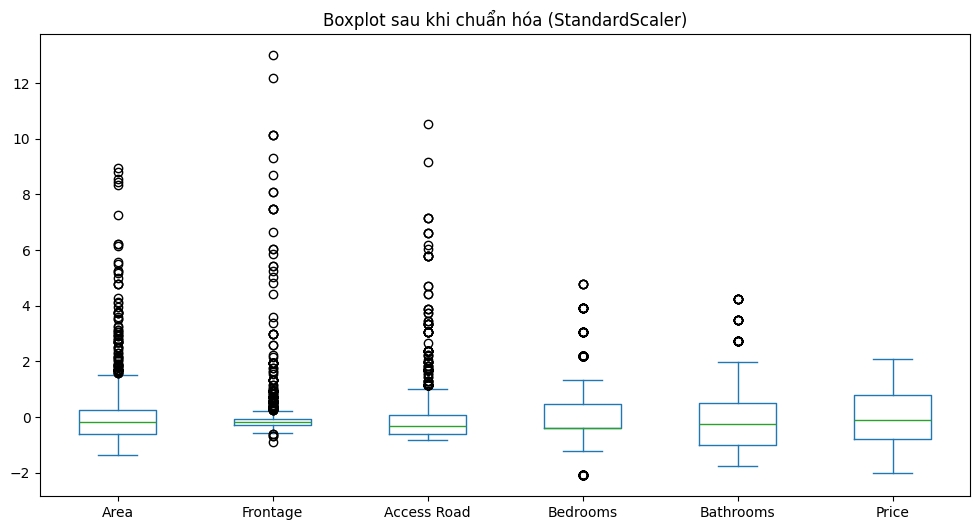

In [19]:
# Vẽ Boxplot sau khi chuẩn hóa
vietnam_housing_clean[cols_to_scale].plot(kind="box", figsize=(12,6), title="Boxplot sau khi chuẩn hóa (StandardScaler)")

Trước / Sau: 1341 / 1310


<Axes: title={'center': 'Boxplot sau khi loại Outlier (IQR)'}>

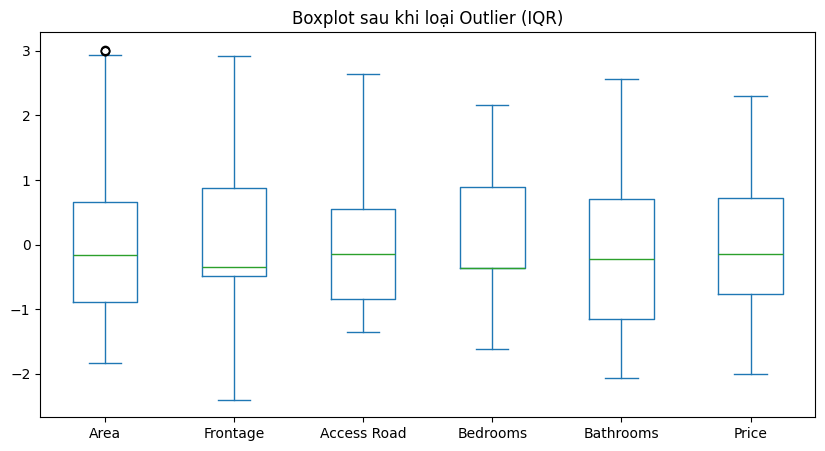

In [22]:
cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms']

mask = np.ones(len(vietnam_housing_clean), bool)
for c in cols:
    q1, q3 = vietnam_housing_clean[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask &= (vietnam_housing_clean[c] >= q1 - 1.5*iqr) & (vietnam_housing_clean[c] <= q3 + 1.5*iqr)

vietnam_housing_clean = vietnam_housing_clean[mask].copy()
print("Trước / Sau:", len(mask), "/", len(vietnam_housing_clean))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms','Price']
vietnam_housing_clean[scale_cols] = scaler.fit_transform(vietnam_housing_clean[scale_cols])

vietnam_housing_clean[scale_cols].plot(kind='box', figsize=(10,5),
    title='Boxplot sau khi loại Outlier (IQR)')


In [23]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms',
        'Price'], dtype=object),
 'n_features_in_': 6,
 'n_samples_seen_': np.int64(1310),
 'mean_': array([-0.24457456, -0.22216888, -0.28949901, -0.13998597, -0.08714456,
        -0.11107982]),
 'var_': array([0.23359703, 0.02242879, 0.15301998, 0.46700098, 0.65484185,
        0.89378255]),
 'scale_': array([0.48331877, 0.14976244, 0.39117769, 0.6833747 , 0.80922299,
        0.94540073])}

In [25]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


,Frontage,Access Road
count,1.310000e+03,1.310000e+03
mean,4.610392e-17,-1.355998e-17
std,1.000382e+00,1.000382e+00
min,-2.400832e+00,-1.358328e+00
25%,-4.895871e-01,-8.368635e-01
50%,-3.530696e-01,-1.415781e-01
75%,8.755877e-01,5.537072e-01
max,2.923350e+00,2.639563e+00


In [27]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


,Frontage,Access Road
count,1.310000e+03,1.310000e+03
mean,4.610392e-17,-1.355998e-17
std,1.000382e+00,1.000382e+00
min,-2.400832e+00,-1.358328e+00
25%,-4.895871e-01,-8.368635e-01
50%,-3.530696e-01,-1.415781e-01
75%,8.755877e-01,5.537072e-01
max,2.923350e+00,2.639563e+00


In [28]:
# xóa các khoảng trắng thay đinh do bằng gạch dưới
vietnam_housing.columns = vietnam_housing.columns.str.replace(' ', '_')

## PHÂN CỤM DỮ LIỆU

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Chuyển các cột phân loại từ boolean thành số
X[cat_cols] = X[cat_cols].astype(int)  # Hoặc .astype(str) nếu muốn chuyển thành chuỗi

# Xử lý NaN cho cột số & phân loại
num_cols = ['Area', 'Access Road', 'Frontage', 'Bedrooms', 'Bathrooms', 'Price',
            'House_direction_sin', 'House_direction_cos',
            'Balcony_direction_sin', 'Balcony_direction_cos']
cat_cols = ['Legal_status_1', 'Furniture_state_1']

# Xử lý NaN cho các cột số (median)
X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])

# Xử lý NaN cho các cột phân loại (most_frequent)
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

# Chuẩn hóa dữ liệu số (scaling)
X[num_cols] = StandardScaler().fit_transform(X[num_cols])

# Kiểm tra lại dữ liệu sau khi xử lý
print(X.head())


           Area  Access Road  Frontage  Bedrooms  Bathrooms     Price  \
27565  0.591360     0.206065 -0.489587  0.899469  -0.217058  0.365011   
18669  0.659884     0.032243  0.875588  0.899469   1.635358 -0.018552   
3572  -0.753425    -0.489221 -0.489587  0.899469   0.709150  1.156112   
921    0.017471    -0.141578 -0.489587 -0.355381  -0.217058 -0.593898   
27815 -0.068184     0.206065 -0.489587 -0.355381  -0.217058 -0.330198   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
27565             2.170291            -1.006457               2.142783   
18669            -0.033648             0.585884              -0.041688   
3572             -0.033648             0.585884              -0.041688   
921              -0.033648             0.585884              -0.041688   
27815            -0.033648             0.585884              -0.041688   

       Balcony_direction_cos  Legal_status_1  Furniture_state_1  
27565              -1.023832               0      

In [38]:
# Chạy KMeans
km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X, km.labels_))
    print(f"k={k} | Inertia={km.inertia_:.2f} | Silhouette={km_scores[-1]:.4f}")


k=3 | Inertia=9173.36 | Silhouette=0.1999
k=4 | Inertia=7793.05 | Silhouette=0.2220
k=5 | Inertia=6962.38 | Silhouette=0.2109
k=6 | Inertia=6172.58 | Silhouette=0.2408
k=7 | Inertia=5847.91 | Silhouette=0.2054
k=8 | Inertia=5568.24 | Silhouette=0.2023
k=9 | Inertia=5375.23 | Silhouette=0.1949


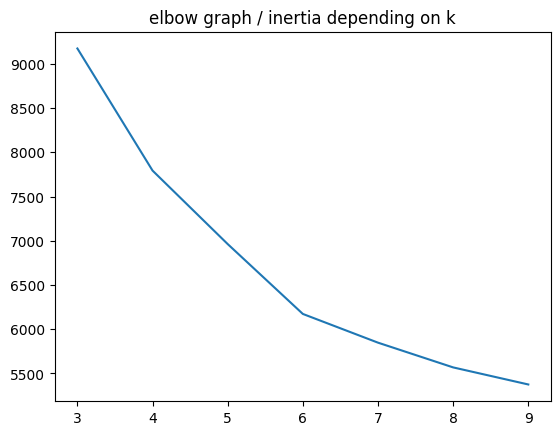

k = 3, Silhouette Score = 0.195
k = 4, Silhouette Score = 0.186
k = 5, Silhouette Score = 0.138
k = 6, Silhouette Score = 0.169
k = 7, Silhouette Score = 0.166
k = 8, Silhouette Score = 0.191
k = 9, Silhouette Score = 0.179


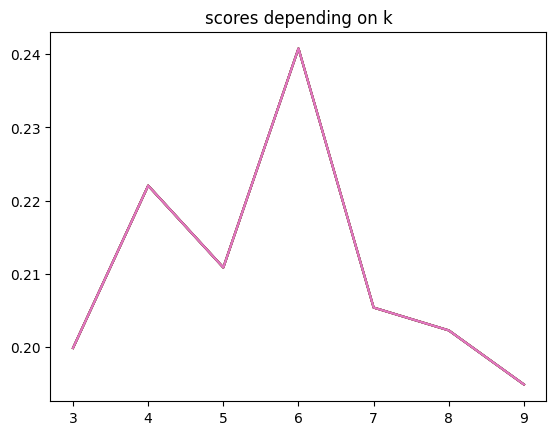

In [39]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    score = silhouette_score(X, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()


In [40]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=4).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(4):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   451.000000  451.000000  451.000000  451.000000  451.000000   
mean     -0.697344   -0.703172   -0.102185   -0.050710   -0.408123   
std       0.494365    0.734195    0.866642    0.701928    0.755204   
min      -1.358328   -2.400832   -1.610232   -2.069473   -1.864453   
25%      -1.010685   -1.172175   -0.355381   -0.217058   -1.001434   
50%      -0.836864   -0.489587   -0.355381   -0.217058   -0.474034   
75%      -0.489221   -0.489587    0.899469    0.709150    0.038982   
max       1.944278    2.240763    2.154320    1.635358    2.258857   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count           451.000000           451.000000             451.000000   
mean              0.220465             0.352859               0.215023   
std               0.734679             0.611396               0.775900   
min              -2.237586            -2.598797           

In [41]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   300.000000  300.000000  300.000000  300.000000  300.000000   
mean      0.132422    0.631676   -0.698374   -0.859229   -0.465053   
std       0.784514    0.871038    0.738599    0.591116    0.809136   
min      -1.184506   -1.854762   -1.610232   -2.069473   -2.008289   
25%      -0.489221   -0.185836   -1.610232   -1.143266   -1.007428   
50%       0.032243    0.875588   -0.355381   -1.143266   -0.593898   
75%       0.553707    0.875588   -0.355381   -0.217058   -0.066498   
max       2.639563    2.923350    2.154320    0.709150    2.067076   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count           300.000000           300.000000             300.000000   
mean              0.304289             0.320494               0.300545   
std               0.835273             0.594422               0.815171   
min              -2.237586            -1.006457           

In [42]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X.shape)
print("Unique cluster labels:", np.unique(X['Label']))
print("Number of duplicates:", vietnam_housing.duplicated().sum())


KMeans n_clusters: 5
Shape of X_scaled: (1310, 13)
Unique cluster labels: [0 1 2 3 4]
Number of duplicates: 0


## DBSCAN

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [45]:
df = vietnam_housing_clean.copy()
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df = df.rename(columns={'Access Road':'Access_Road'})
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df.rename(columns={'Access Road':'Access_Road'}, inplace=True)

feat = ['Area','Access_Road','Frontage','Bedrooms','Bathrooms','Price',
        'House_direction_sin','House_direction_cos',
        'Balcony_direction_sin','Balcony_direction_cos']
feat = [c for c in feat if c in df.columns]  # chỉ giữ cột có thật
X = df[feat].copy()